In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

Langevin equation:

$$ m \ddot{x}\left(t\right) = - \int_0^t \frac{2 m \gamma}{\pi} \frac{\epsilon}{\epsilon^2 + \left(t - \tau\right)^2} \dot{x}\left(\tau\right) d \tau + \xi\left(t\right) $$

Where

$$ \left\langle \xi\left(t\right) \xi\left(t+\tau\right) \right\rangle = \frac{2 \gamma m}{ \pi} \frac{\epsilon^2 - \tau^2}{\left(\epsilon^2+\tau^2\right)^2}$$

Let us generate the noise sample $ \xi\left(t\right) $:

In [79]:
# generate random noise sample
w_max = 200
w = np.linspace(0, w_max, num=120000)
n_w = len(w)
dw = w[1] - w[0]
epsilon = 0.1
sqrt_J = np.zeros(n_w, dtype=complex)

for i in range(n_w):
    sqrt_J[i] = math.sqrt(dw / 2) * math.sqrt(w[i] * math.exp(-epsilon * w[i]))

t_max = 4000
t = np.linspace(0, t_max, num=400000)
dt = t[1] - t[0]
n_t = len(t)

z = np.random.normal(size=n_w) + 1j * np.random.normal(size=n_w)
z = z / math.sqrt(2)
xi = np.zeros(n_t, dtype=complex)
for j in range(n_t):
    e = np.exp(-1j * w * t[j])
    xi_pos = z * sqrt_J * e
    xi_neg = xi_pos.conjugate()
    xi[j] = np.sum(xi_pos) + np.sum(xi_neg[1:]) 

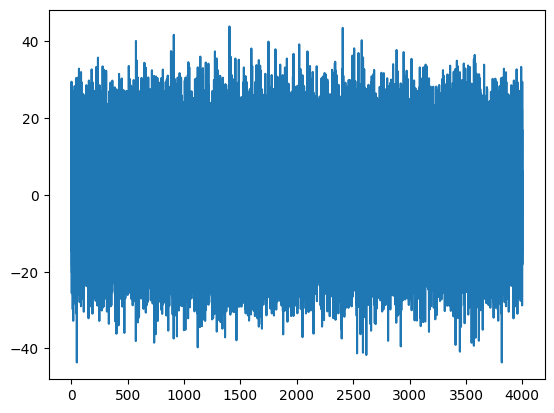

In [80]:
# how the noise looks like
plt.plot(t, xi)
#plt.xlim(0, 10)

Define memory function:

$$ M\left(t\right) =  \frac{\epsilon}{\epsilon^2 + \left(t - \tau\right)^2} $$

In [81]:
M = np.zeros(n_t) 

for i in range(n_t):
    M[i] = epsilon / (epsilon**2 + (t[i] - t[0])**2) * dt

(0.0, 1.0)

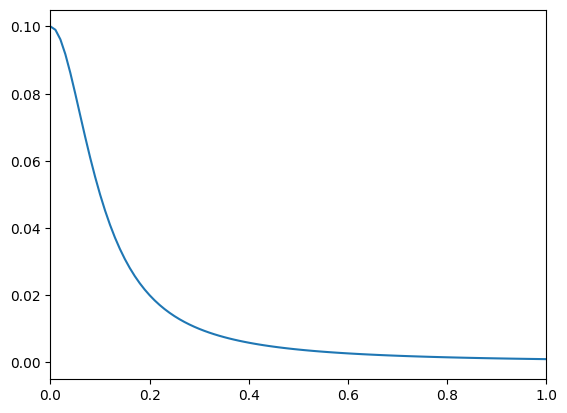

In [82]:
# how the memory M(t) looks like
plt.plot(t, M)
plt.xlim(0, 1)

Let us solve the Langevin equation:

In [83]:
def ode_midpoint(dt, RHS, initial_state, start_time = None, start_index = None, end_time = None, end_index = None, tol = 10**(-6)):

    K = initial_state.size

    use_time = False
    use_index = False

    if not start_time is None and not end_time is None:

        use_time = True
        nt = math.floor((end_time - start_time) / dt)

    if not start_index is None and not end_index is None:

        use_index = True
        nt = end_index - start_index

    if not use_index != use_time:
        raise ValueError('evolution should be called either in time or in step-index mode')


    if (use_index):
        yield (start_index, initial_state)
    else:
        yield (start_time, initial_state)

    psi = np.copy(initial_state)
    psi_mid = np.copy(psi)

    b = nt - 1

    for i in range(0, b):

        psi_mid[:] = psi

        if (use_index):
            
            time_moment = start_index + i
            
        else:
            
            time_moment = start_time + (i + 0.5) * dt
            
        while(True):

            psi_mid_next = RHS(time_moment, psi_mid)

            psi_mid_next = psi + dt / 2 * psi_mid_next

            err = max(abs(psi_mid_next - psi_mid))

            swp = psi_mid_next
            psi_mid_next = psi_mid
            psi_mid = swp

            if err < tol:
                break

        psi = 2 * psi_mid - psi

        if (use_index):
            yield (start_index + i + 1, psi)
        else:
            yield (start_time + i * dt, psi)

Langevin equation in terms of momentum:

$$ m \dot{p}\left(t\right) = - \int_0^t \frac{2 m \gamma}{\pi} \frac{\epsilon}{\epsilon^2 + \left(t - \tau\right)^2} p\left(\tau\right) d \tau + \xi\left(t\right) $$

In [84]:
p0 = np.array([0])

p_trajectory = []
t_axis = []

def RHS(ti, p_mid):
    n_memory = len(p_trajectory)
    rhs = -sum(M[:n_memory+1] * ([p_mid[0]] + p_trajectory[::-1])) + (xi[ti] + xi[ti + 1]) / 2
    return rhs

for ti, p in ode_midpoint(dt, RHS, p0, start_index = 0, end_index = n_t - 1):
    p_trajectory.append(p[0])
    t_axis.append(ti * dt)

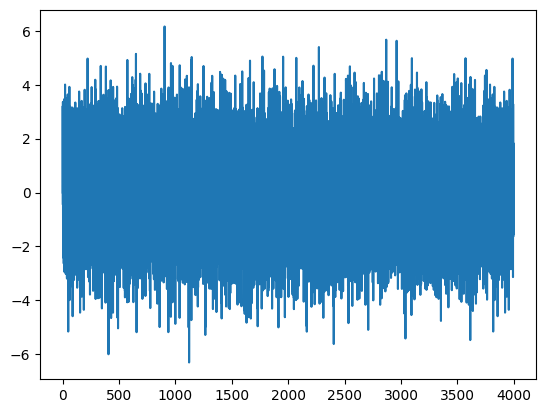

In [85]:
plt.plot(t_axis, p_trajectory)

In [86]:
# integrate
x_trajectory = [0]
for i in range(1, len(p_trajectory)):
    x = x_trajectory[i - 1] + p_trajectory[i] * dt
    x_trajectory.append(x)

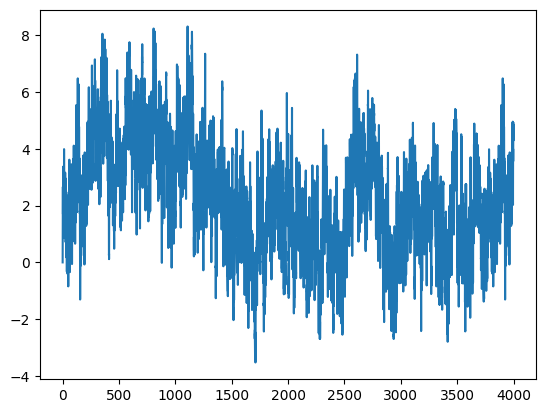

In [87]:
plt.plot(t_axis, x_trajectory)

In [88]:
# Dispersion along trajectory

n_window = 3000
x2 = np.zeros(n_window)

for i in range(len(x_trajectory) - n_window):
    for j in range(n_window):
        x2[j] += (x_trajectory[i + j] - x_trajectory[i])**2

x2 = x2 / (len(x_trajectory) - n_window)


/tmp/ipykernel_51899/2920044725.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  x2[j] += (x_trajectory[i + j] - x_trajectory[i])**2


In [67]:
x2_sqr = np.sqrt(x2)

In [68]:
(len(x_trajectory) - n_window)

96999

My choice of parameters corresponds to

$$ m = 1 ,$$
$$ \gamma = \pi / 2. $$

Use asymptotic formula:

$$\left\langle x^2\left(t\right) \right\rangle = \frac{1}{\pi m \gamma} \log\left(\gamma t\right)$$ 

In [89]:
c = 1/4.0 * math.log(2 / math.pi / epsilon)
D0 = 1 / c
D = D0 + 4 / math.pi**2 / D0

/tmp/ipykernel_51899/2820134523.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(t_axis[:n_window], (D + 2 / math.pi**2 * np.log(np.array(t_axis[:n_window]) * math.pi / 2))/2)


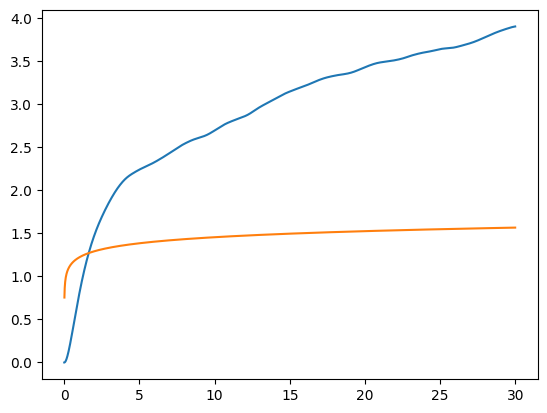

In [90]:
plt.plot(t_axis[:n_window], x2)
plt.plot(t_axis[:n_window], (D + 2 / math.pi**2 * np.log(np.array(t_axis[:n_window]) * math.pi / 2))/2)

/tmp/ipykernel_51899/1094812373.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(t_axis[:n_window], (D + 2 / math.pi**2 * np.log(np.array(t_axis[:n_window]) * math.pi / 2))/2)


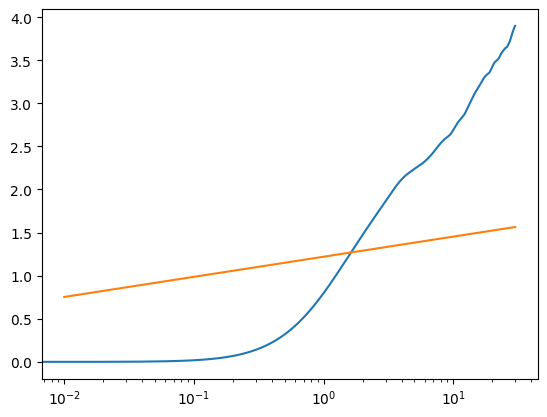

In [91]:
plt.plot(t_axis[:n_window], x2)
plt.plot(t_axis[:n_window], (D + 2 / math.pi**2 * np.log(np.array(t_axis[:n_window]) * math.pi / 2))/2)
plt.xscale('log')

/tmp/ipykernel_51899/922930940.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(t_axis[:n_window],  x2 - 2 / math.pi**2 * np.log(np.array(t_axis[:n_window]) * math.pi / 2) - D)


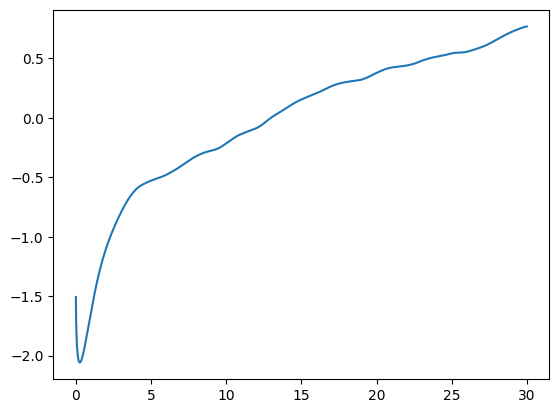

In [92]:
plt.plot(t_axis[:n_window],  x2 - 2 / math.pi**2 * np.log(np.array(t_axis[:n_window]) * math.pi / 2) - D)

In [41]:
np.log(math.pi / 2)

np.float64(0.4515827052894548)

1.3385673700680571